<a href="https://colab.research.google.com/github/aclightbody/MIoT_Project/blob/main/Project_ESP32_MPU6050_DMP6/Scripts/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training is much faster using GPU acceleration. Before you proceed, ensure you are using a GPU runtime by going to **Runtime -> Change runtime type** and selecting **GPU**. Training will take around 5 minutes on a GPU runtime.

In [1]:
# Clone repository from GitHub
!git clone https://github.com/aclightbody/MIoT_Project.git

fatal: destination path 'MIoT_Project' already exists and is not an empty directory.


In [2]:
import csv
import pandas
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
import os
# from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import StratifiedKFold

# https://stackoverflow.com/questions/55424906/building-svm-with-tensorflows-linearclassifier-and-pandas-dataframes
# https://aiplanet.com/notebooks/2418/binthamza/svm-classification-with-tfkeras-model
# https://stackoverflow.com/questions/55424906/building-svm-with-tensorflows-linearclassifier-and-pandas-dataframes
# https://www.kaggle.com/code/shadesh/svm-classification-using-tensorflow-and-keras
# https://medium.com/low-code-for-advanced-data-science/support-vector-machines-svm-an-intuitive-explanation-b084d6238106

cwd = os.getcwd()
print(cwd)

path = '/content/MIoT_Project/Project_ESP32_MPU6050_DMP6/Data'
dataDrop = pandas.read_csv(path + "/FeatureExtractDrop.csv").values
dataWalk = pandas.read_csv(path + "/FeatureExtractWalk.csv").values

/content


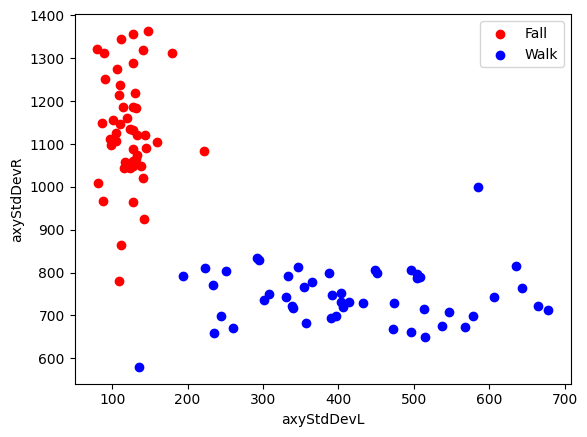

In [3]:
nTest = 5

# Features
x_total = dataDrop[:, 1:]
x_total = numpy.append(x_total, dataWalk[:,1:], axis=0)
x_trainVal = dataDrop[nTest:, 1:]
x_trainVal = numpy.append(x_trainVal, dataWalk[nTest:,1:], axis=0)
x_test = dataDrop[:nTest, 1:]
x_test = numpy.append(x_test,dataWalk[:nTest, 1:], axis=0)

# Labels
y_total = dataDrop[:, 0]
y_total = numpy.append(y_total,dataWalk[:,0], axis=0)
y_trainVal = dataDrop[nTest:, 0]
y_trainVal = numpy.append(y_trainVal,dataWalk[nTest:,0], axis=0)
y_trainVal = numpy.where(y_trainVal==1, y_trainVal, 0) # Converting -1 to 0, to have 0 and 1 labels. Normally would have binary labels as -1 and +1 for hinge loss, but tf.keras.losses.Hinge() expects 0 and +1. If doing custom hinge loss function, then labels would be -1 and +1 e.g. https://stackoverflow.com/questions/55424906/building-svm-with-tensorflows-linearclassifier-and-pandas-dataframes
y_test = dataDrop[:nTest, 0]
y_test = numpy.append(y_test,dataWalk[:nTest,0], axis=0)
y_test = numpy.where(y_test==1, y_test, 0)

plt.scatter(dataDrop[:,1], dataDrop[:,2], c='red', label='Fall')
plt.scatter(dataWalk[:,1], dataWalk[:,2], c='blue', label='Walk')
plt.xlabel("axyStdDevL")
plt.ylabel("axyStdDevR")
plt.legend(loc="upper right")
plt.show()

In [4]:
def get_model():
    #Linear SVM model
    model = tf.keras.Sequential()
    # Metric: is a function to assess model performance. Similar to loss functions, except that the results from evaluating a metric are not used when training the model. Note that you may use any loss function as a metric.
    # Optimizer: adam is a commonly used one. Learning rate: step size when adjusting paramters in model (usually 0.001 to 0.1). Larger learning rate reduces iterations but reduces accuracy, smaller rate gives higher accuracy and more iterations. https://stackoverflow.com/questions/59737875/keras-change-learning-rate
    # Dense layer of 1 means that this layer has one neuron (unit). Since only one layer (output layer) is being added with one neuron, it's linear.
    # Activation function: mathematical function applied to the neuron output in a neural layer. These are used to introduce non-linearity in a neural network. Linear (pass through): input unmodified. https://keras.io/api/layers/activations/.
    # Kernel regularizer: Typical values for the regularisation parameters are 1 to 10, 10 being default. https://keras.io/api/layers/regularizers/. L1 and L2 regularizers have default of 0.01. The L2 regularization penalty is computed as: loss = l2 * reduce_sum(square(x)).Kernel regularizer tries to reduce the weights (excluding bias). https://stats.stackexchange.com/questions/383310/what-is-the-difference-between-kernel-bias-and-activity-regulizers-and-when-t
    # Loss: Hinge loss is equivalent to slack variable. Custom loss function used for hinge loss https://keras.io/api/losses/. https://keras.io/api/losses/hinge_losses/.
    # Kernel: linear, polynomial, guassian, sigmoid, etc
    optmzr = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.add(tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(1)))
    model.compile(optimizer=optmzr, loss=tf.keras.losses.Hinge(), metrics=["accuracy"])
    return model

In [5]:
# https://medium.com/@literallywords/stratified-k-fold-with-keras-e57c487b1416
# https://machinelearningmastery.com/k-fold-cross-validation/
# k-cross validation is used to evaluate the model in terms of bias, variance and whether the model is general enough to accurately predict with unseen data.
# k-cross validation is not used to create the overall model.
# Instantiate the cross validator
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True)
sumAcc = 0
sumAccVal = 0
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(x_trainVal, y_trainVal)):
    print ("Training on fold " + str(index+1) + "/" + str(k) + "...")
    # Generate batches from indices
    xtrain, xval = x_trainVal[train_indices], x_trainVal[val_indices]
    ytrain, yval = y_trainVal[train_indices], y_trainVal[val_indices]
    # Clear model, and create it
    model = None
    model = get_model()

    # Debug message I guess
    # print "Training new iteration on " + str(xtrain.shape[0]) + " training samples, " + str(xval.shape[0]) + " validation samples, this may be a while..."

    history = model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=100, verbose=False)
    accuracy_history = history.history['accuracy']
    val_accuracy_history = history.history['val_accuracy']
    sumAcc += accuracy_history[-1]
    sumAccVal += val_accuracy_history[-1]
    print("Last training accuracy: " + str(accuracy_history[-1]) + ", last validation accuracy: " + str(val_accuracy_history[-1]))


avgAcc = sumAcc / k
avgAccVal = sumAccVal / k
print("Average training accuracy: " + str(avgAcc) + ", average validation accuracy: " + str(avgAccVal))


Training on fold 1/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 2/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 3/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 4/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 5/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 6/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 7/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 8/10...
Last training accuracy: 1.0, last validation accuracy: 0.8888888955116272
Training on fold 9/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Training on fold 10/10...
Last training accuracy: 1.0, last validation accuracy: 1.0
Average training accuracy: 1.0, average validation accuracy: 0.9888888895511627


In [6]:
# TODO: Implement model that is trained by all training data
# model = None
# model = get_model()

In [7]:
# batch_size: Number of samples per gradient update. If unspecified, batch_size will default to 32. The batch size is the number of training examples that you use to perform one step of stochastic gradient descent (SGD). https://stackoverflow.com/questions/61029052/what-is-the-batchsize-in-tensorflows-model-fit-function
# history = model.fit(x, y, epochs=50, verbose=False, batch_size=32) # Need to update this to split into to training and validation data
print("Finished training the model")
model.summary()

Finished training the model


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11 (48.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8 (36.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
tf.Tensor(
[[5 0]
 [1 4]], shape=(2, 2), dtype=int32)


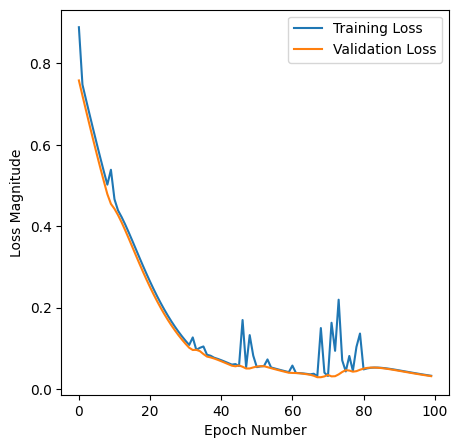

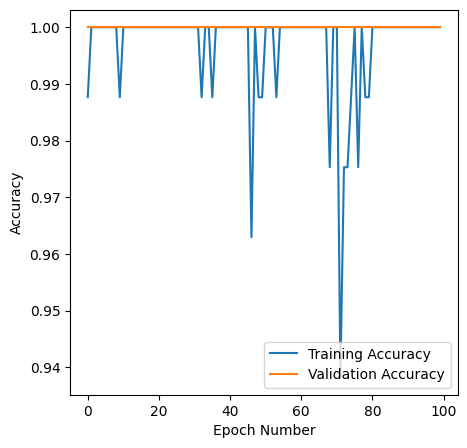

<Figure size 500x500 with 0 Axes>

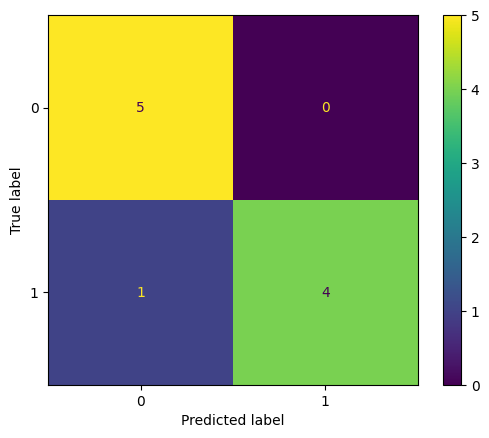

Confusion accuracy: 0.9
Confusion sensitivity: 0.8
Confusion specificity: 1.0
Confusion precision: 1.0


In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(5, 5))
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc="upper right")

plt.figure(figsize=(5, 5))
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc="lower right")

# Predicting class with test data for confusion matrix
# pred = numpy.argmax(model.predict(xval), axis=1)
pred = numpy.where(model.predict(x_test) > 0, 1, 0) # Binary class prediction, if prediction -ve class is 0, +ve prediction class is 1. https://stackoverflow.com/questions/68776790/model-predict-classes-is-deprecated-what-to-use-instead
confusion = tf.math.confusion_matrix(labels=tf.constant(y_test), predictions=tf.constant(pred), num_classes=2)
print(confusion)

plt.figure(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()
# loss, acc = model.evaluate(test_data)
# print("Loss {}, Accuracy {}".format(loss, acc))

TN = confusion.numpy()[0][0] # True negative
TP = confusion.numpy()[1][1] # True positive
FN = confusion.numpy()[1][0] # False negative
FP = confusion.numpy()[0][1] # False positive

Conf_accuracy = (TP + TN)/(TP + TN + FP + FN)
Conf_sensitivity = TP/(TP + FN)
Conf_specificity = TN/(TN + FP)
Conf_precision = TP/(TP + FP)
print("Confusion accuracy: " + str(Conf_accuracy))
print("Confusion sensitivity: " + str(Conf_sensitivity))
print("Confusion specificity: " + str(Conf_specificity))
print("Confusion precision: " + str(Conf_precision))


In [9]:
# print(f' W: {model.weights}')
w = model.get_weights()[0] # weight vector w0, w1
b = model.get_weights()[1] # bias, b

# Same as above
print(model.layers[0].kernel.numpy()) # Weight vector
print(model.layers[0].bias.numpy()) # Bias

# Hyperplane
# w.x + b = 0
# w0*x0 + w1*x1 + b = 0
# y = mx + c --> x1 = -(w0/w1)*x0 - b/w1
# https://vitalitylearning.medium.com/support-vector-machines-with-tensorflow-4fb345f01bca
# https://wadhwatanya1234.medium.com/support-vector-machine-bbbafec9c591
m = - w[0]/w[1] # gradient
c = - b[0]/w[1] # constant

xSep          = [i[0] for i in x_total]
ySep          = [m * i + c for i in xSep]

[[-0.17387469]
 [ 0.03377036]]
[-0.13967952]


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

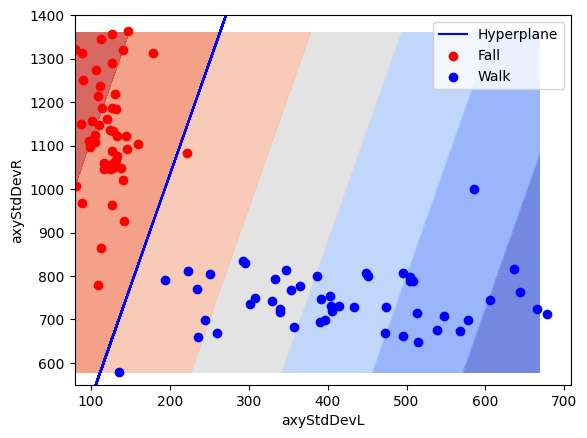

In [10]:
# prediction = model.predict_generator(test, verbose=1)
# plot_decision_regions(x, y, clf=model, legend=2) # Another function to

x_min, x_max = x_total[:, 0].min() - 1, x_total[:, 0].max() + 1
y_min, y_max = x_total[:, 1].min() - 1, x_total[:, 1].max() + 1
xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, 10),numpy.arange(y_min, y_max, 10)) # Had to put mesh grid to 1 or above, since axes are on the order of 100
Z = model.predict(numpy.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Set1)
# plt.plot(numpy.reshape(xSep, (len(xSep), 1)), numpy.reshape(ySep, (len(ySep), 1)), 'b-', label='Dividing line')
plt.plot(xSep, ySep, 'b-', label='Hyperplane')
plt.scatter(dataDrop[:,1], dataDrop[:,2], c='red', label='Fall')
plt.scatter(dataWalk[:,1], dataWalk[:,2], c='blue', label='Walk')
plt.xlabel("axyStdDevL")
plt.ylabel("axyStdDevR")
plt.legend(loc="upper right")
plt.ylim(550,1400)
plt.show

In [11]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("/content/MIoT_Project/Project_ESP32_MPU6050_DMP6/model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converterQ = tf.lite.TFLiteConverter.from_keras_model(model)
converterQ.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_modelQ = converter.convert()

# Save the model to disk
open("/content/MIoT_Project/Project_ESP32_MPU6050_DMP6/model_quantized.tflite", "wb").write(tflite_modelQ)

basic_model_size = os.path.getsize("/content/MIoT_Project/Project_ESP32_MPU6050_DMP6/model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("/content/MIoT_Project/Project_ESP32_MPU6050_DMP6/model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Saved artifact at '/tmp/tmpngl8bhhn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140577368478944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140577240183056: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/tmp/tmp8lf966u3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140577368478944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140577240183056: TensorSpec(shape=(), dtype=tf.resource, name=None)
Basic model is 1120 bytes
Quantized model is 1120 bytes
Difference is 0 bytes


In [12]:
# Convert model into hex dump that is inserted into C++ source file
# https://towardsdatascience.com/tensorflow-on-arduino-b336f08fa0e9
# https://github.com/stefan-spiss/MagicWand-TFLite-ESP32-MPU6050.git
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!xxd -i "/content/MIoT_Project/Project_ESP32_MPU6050_DMP6/model.tflite" > /content/MIoT_Project/Project_ESP32_MPU6050_DMP6/model.cpp
# Print the source file
# Remember to copy the hex dump content and the g_model_len into the C++ file
!cat /content/MIoT_Project/Project_ESP32_MPU6050_DMP6/model.cpp

unsigned char _content_MIoT_Project_Project_ESP32_MPU6050_DMP6_model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x98, 0x00, 0x00, 0x00, 0xf0, 0x00, 0x00, 0x00, 0xcc, 0x01, 0x00, 0x00,
  0xdc, 0x01, 0x00, 0x00, 0x0c, 0x04, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x6f, 0x75, 0x74, 0x70,
  0x75, 0x74, 0x5f, 0x30, 0x00